In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tqdm
import random
import re
from keras.preprocessing.image import load_img
from keras.applications.xception import Xception
warnings.filterwarnings('ignore')

In [2]:
input_path = []
label = []
for class_name in tqdm.tqdm(os.listdir("images")):
     for path in os.listdir("images/"+class_name):
            if re.search("^id[0]_", path):
                for image_path in os.listdir("images/"+class_name+"/"+path):
                    if class_name == 'celeb-real-imgs':
                        label.append(0)
                    else: 
                        label.append(1) 
                    input_path.append(os.path.join("images", class_name, path, image_path))
# print(input_path[0], label[0])  

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/it]


In [3]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,images\Celeb-synthesis-imgs\id0_id4_0006\frame...,1
1,images\Celeb-synthesis-imgs\id0_id1_0003\frame...,1
2,images\Celeb-synthesis-imgs\id0_id17_0006\fram...,1
3,images\Celeb-synthesis-imgs\id0_id16_0007\fram...,1
4,images\Celeb-synthesis-imgs\id0_id20_0003\fram...,1


In [4]:
#DB FILES
for i in df['images']:
    if '.jpg' not in i:
        print(i)

In [5]:
#DELETE DB FILES
# df = df[df['images']!=images/Cat/Thumbs.db']
# df = df[df['images']!='PetImages/Dog/Thumbs.db']
# len(df)

In [6]:
# import PIL
# l = []
# for image in tqdm.tqdm(df['images']):
#     try:
#         img = PIL.Image.open(image)
#     except:
#         l.append(image)

In [7]:
#deleting the both DB and corrupted Images
# df = df[df['images']!='PetImages/Cat/Thumbs.db']
# df = df[df['images']!='PetImages/Dog/Thumbs.db']
# df = df[df['images']!='PetImages/Cat/666.jpg']
# df = df[df['images']!='PetImages/Dog/11702.jpg']
# len(df)


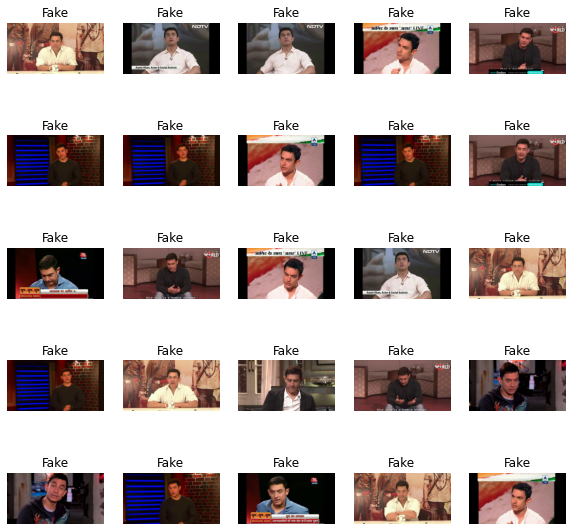

In [8]:
#DISPLAY GRID OF IMAGE
plt.figure(figsize=(10,10))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]
for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Fake')
    plt.axis('off')

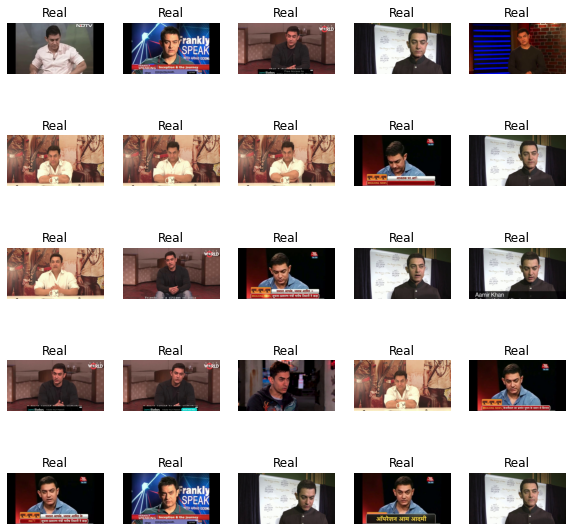

In [9]:
#DISPLAY GRID OF IMAGE
plt.figure(figsize=(10,10))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]
for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Real')
    plt.axis('off')

<AxesSubplot:xlabel='label', ylabel='count'>

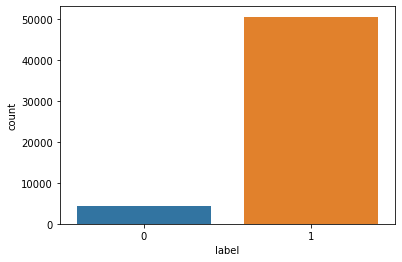

In [10]:
import seaborn as sns
sns.countplot(df['label'])

In [11]:
df['label'] = df['label'].astype('str')
df.head()

,images,label
0,images\Celeb-synthesis-imgs\id0_id4_0006\frame...,1
1,images\Celeb-synthesis-imgs\id0_id1_0003\frame...,1
2,images\Celeb-synthesis-imgs\id0_id17_0006\fram...,1
3,images\Celeb-synthesis-imgs\id0_id16_0007\fram...,1
4,images\Celeb-synthesis-imgs\id0_id20_0003\fram...,1


In [12]:
#INPUT SPLIT
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [13]:
print(f'Training Data has {train.shape[0]} records')
print(f'Validation Data has {val.shape[0]} records')
print(f'Testing Data has {test.shape[0]} records')

Training Data has 35187 records
Validation Data has 8797 records
Testing Data has 10996 records


In [14]:
train.head()

,images,label
7071,images\Celeb-synthesis-imgs\id0_id23_0007\fram...,1
28710,images\Celeb-synthesis-imgs\id0_id16_0007\fram...,1
38218,images\Celeb-synthesis-imgs\id0_id4_0006\frame...,1
46179,images\Celeb-synthesis-imgs\id0_id1_0009\frame...,1
18330,images\Celeb-synthesis-imgs\id0_id1_0000\frame...,1


In [15]:
test.head()

,images,label
48463,images\Celeb-synthesis-imgs\id0_id3_0003\frame...,1
39175,images\celeb-real-imgs\id0_0002\frame20.jpg,0
54795,images\Celeb-synthesis-imgs\id0_id17_0006\fram...,1
5169,images\Celeb-synthesis-imgs\id0_id17_0006\fram...,1
42650,images\Celeb-synthesis-imgs\id0_id28_0003\fram...,1


In [16]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
rescale = 1./255,
rotation_range = 40,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True,
fill_mode = 'nearest'
)
val_generator = ImageDataGenerator(rescale = 1./255)

test_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)
val_iterator = val_generator.flow_from_dataframe(
    val,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'   
)

test_iterator = test_generator.flow_from_dataframe(
    test,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'   
)

Found 35187 validated image filenames belonging to 2 classes.
Found 8797 validated image filenames belonging to 2 classes.
Found 10996 validated image filenames belonging to 2 classes.


# FINE TUNING

In [17]:
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)

def create_model(trainable_layer_count):

    input_tensor = Input(shape=(128, 128, 3))

    base_model = Xception(include_top=False, weights="imagenet", input_tensor=input_tensor)

    if trainable_layer_count == "all":
        #the full pre-trained model is fine-tuned in this case
        for layer in base_model.layers:
            layer.trainable = True
    else:
        #if not all should be trainable, first set them all as non-trainable (fixed)
        for layer in base_model.layers:
            layer.trainable = False

        #and finally set the last N layers as trainable
        #idea is to re-use higher level features and fine-tune the finer details
        for layer in base_model.layers[-trainable_layer_count:]:
            layer.trainable = True

    print("base model has {} layers".format(len(base_model.layers)))

    #here on it is the fully custom classification on top of pre-trained layers above
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(5e-4))(x)
    x = Dropout(0.5)(x)

    #doing binary prediction, so just 1 neuron is enough
    final_output = Dense(1, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [18]:
model = create_model(5)

base model has 132 layers


In [19]:
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
# from sklearn.model_selection import train_test_split


checkpoint = ModelCheckpoint('working/Resnet50_best.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='auto', min_delta=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=7)

csv_logger = CSVLogger(filename='working/training_log.csv',
                       separator=',',
                       append=True)
callbacks_list = [early, reduceLROnPlat]

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

 dropout_1 (Dropout)            (None, 1024)         0           ['dense[0][0]']                  
                                                                                                  
 final_output (Dense)           (None, 1)            1025        ['dropout_1[0][0]']              
                                                                                                  
Total params: 22,960,681
Trainable params: 5,265,921
Non-trainable params: 17,694,760
__________________________________________________________________________________________________


In [23]:
from IPython.core import history
history = model.fit(train_iterator, batch_size=450, epochs=10, validation_data=val_iterator, callbacks=callbacks_list)

Epoch 1/10
69/69 [==============================] - 2786s 40s/step - loss: 0.5847 - accuracy: 0.9180 - val_loss: 0.4170 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 2/10
69/69 [==============================] - 2744s 40s/step - loss: 0.3738 - accuracy: 0.9180 - val_loss: 0.3464 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 3/10
69/69 [==============================] - 2649s 38s/step - loss: 0.3236 - accuracy: 0.9180 - val_loss: 0.2860 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 4/10
69/69 [==============================] - 2669s 39s/step - loss: 0.2996 - accuracy: 0.9182 - val_loss: 0.2715 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 5/10
69/69 [==============================] - 2665s 39s/step - loss: 0.2851 - accuracy: 0.9185 - val_loss: 0.2643 - val_accuracy: 0.9236 - lr: 0.0010
Epoch 6/10
69/69 [==============================] - 2661s 38s/step - loss: 0.2782 - accuracy: 0.9183 - val_loss: 0.2501 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 7/10
69/69 [==============================] - 2668s 39s/st

In [24]:
filename = 'model_2.h5'
model.save(filename)

In [25]:
model.predict(test_iterator)

array([[0.98288584],
       [0.97253346],
       [0.9951184 ],
       ...,
       [0.97438824],
       [0.95894265],
       [0.987969  ]], dtype=float32)

In [33]:
test_scores = model.evaluate_generator(test_iterator)

In [34]:
print(f'Test Accuracy {test_scores[1]*100}%')

Test Accuracy 92.45179891586304%


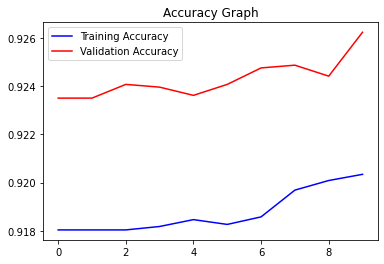

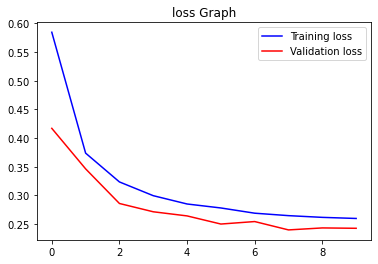

<Figure size 432x288 with 0 Axes>

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('loss Graph')
plt.legend()
plt.figure()
plt.show()